# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('JointHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['JOINT']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-12-16 10:15:32,287|JointHoldingsAdjustement|INFO|Python version: 3.8.15
2022-12-16 10:15:32,287|JointHoldingsAdjustement|INFO|Pandas version: 1.5.2


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-12-16 10:15:32,303|JointHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-12-16 10:15:33,436|JointHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-12-11 00:00:00|2022-12-09 00:00:00
2022-12-16 10:15:33,467|JointHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-12-16 10:15:33,467|JointHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-12-16 10:15:33,686|JointHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-12-16 10:15:33,702|JointHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.015
2022-12-16 10:15:33,702|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.2
2022-12-16 10:15:33,702|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-12-16 10:18:59,835|JointHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.87|501->438


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-12-16 10:18:59,856|JointHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|438
2022-12-16 10:18:59,976|JointHoldingsAdjustement|INFO|OPT_DATE|2022-12-09 00:00:00


2022-12-16 10:19:13,870|JointHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01500000


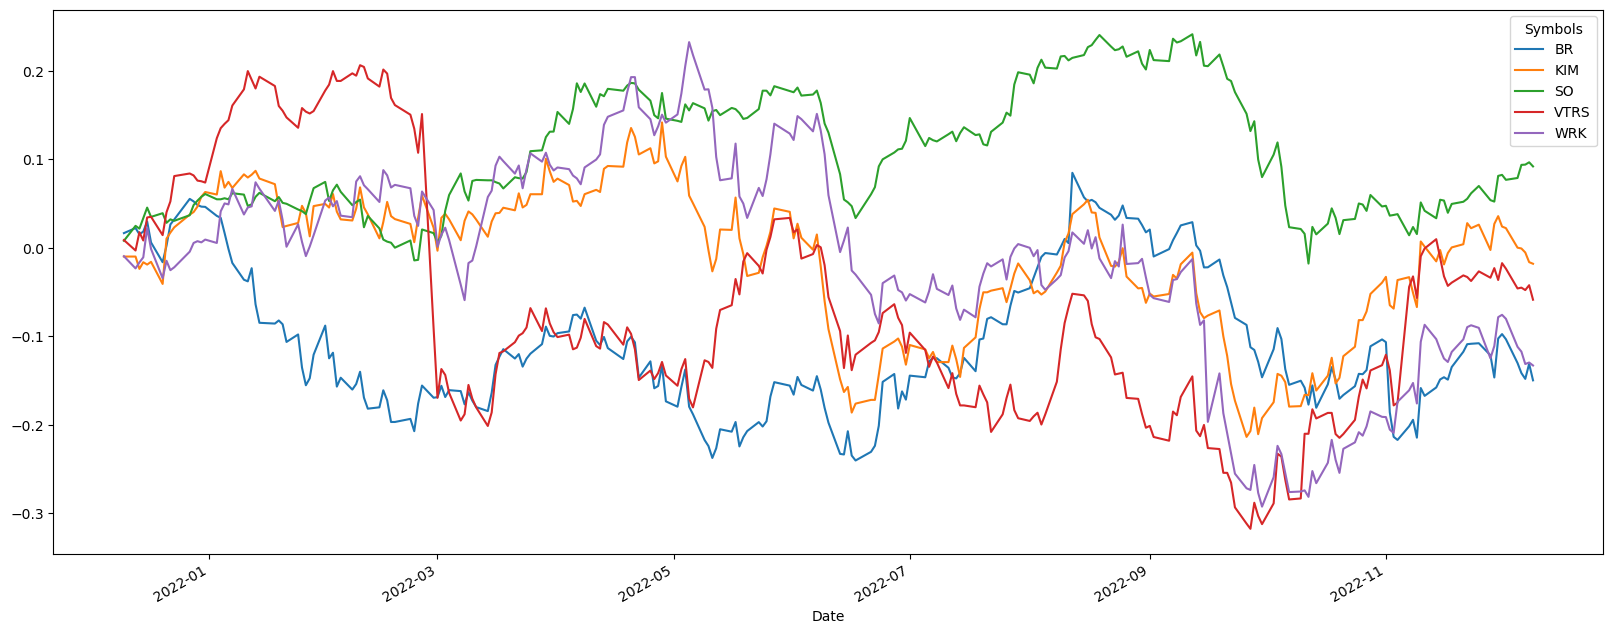

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-12-16 10:19:14,246|JointHoldingsAdjustement|INFO|STOCK|BR                  |HOLDING|0.200000
2022-12-16 10:19:14,247|JointHoldingsAdjustement|INFO|STOCK|KIM                 |HOLDING|0.200000
2022-12-16 10:19:14,248|JointHoldingsAdjustement|INFO|STOCK|SO                  |HOLDING|0.200000
2022-12-16 10:19:14,249|JointHoldingsAdjustement|INFO|STOCK|VTRS                |HOLDING|0.147486
2022-12-16 10:19:14,249|JointHoldingsAdjustement|INFO|STOCK|WRK                 |HOLDING|0.200000


In [9]:
td_ameritrade = amc.AmeritradeRest()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,11133T103,BR,"Broadridge Financial Solutions, Inc. Common Stock",NYSE,EQUITY,185.400,131.35,2.90,2.15,2022-12-14 00:00:00.000,...,13.68304,0.0,0.0,0.0,0.725,2023-01-05 00:00:00.000,0.93774,501990.0,501994.0,13620140.0
1,96145D105,WRK,Westrock Company Common Stock,NYSE,EQUITY,54.780,30.08,1.10,3.07,2022-11-09 00:00:00.000,...,1.97771,0.0,0.0,0.0,0.275,2022-11-23 00:00:00.000,1.14353,1819720.0,1819717.0,47066330.0
2,92556V106,VTRS,Viatris Inc. - Common Stock,NASDAQ,EQUITY,15.600,8.42,0.48,4.31,2022-11-22 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.120,2022-12-16 00:00:00.000,1.17400,6733240.0,6733237.0,207206950.0
3,842587107,SO,Southern Company (The) Common Stock,NYSE,EQUITY,80.570,60.71,2.72,3.87,2022-11-18 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.680,2022-12-06 00:00:00.000,0.49237,4814430.0,4814429.0,96738970.0
4,49446R109,KIM,Kimco Realty Corporation Common Stock,NYSE,EQUITY,26.565,17.71,0.92,4.27,2022-12-08 00:00:00.000,...,5.35717,0.0,0.0,0.0,0.230,2022-12-23 00:00:00.000,1.40760,4443850.0,4443853.0,102112110.0


Tickers:   0%|          | 0/5 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/5 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_10596\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


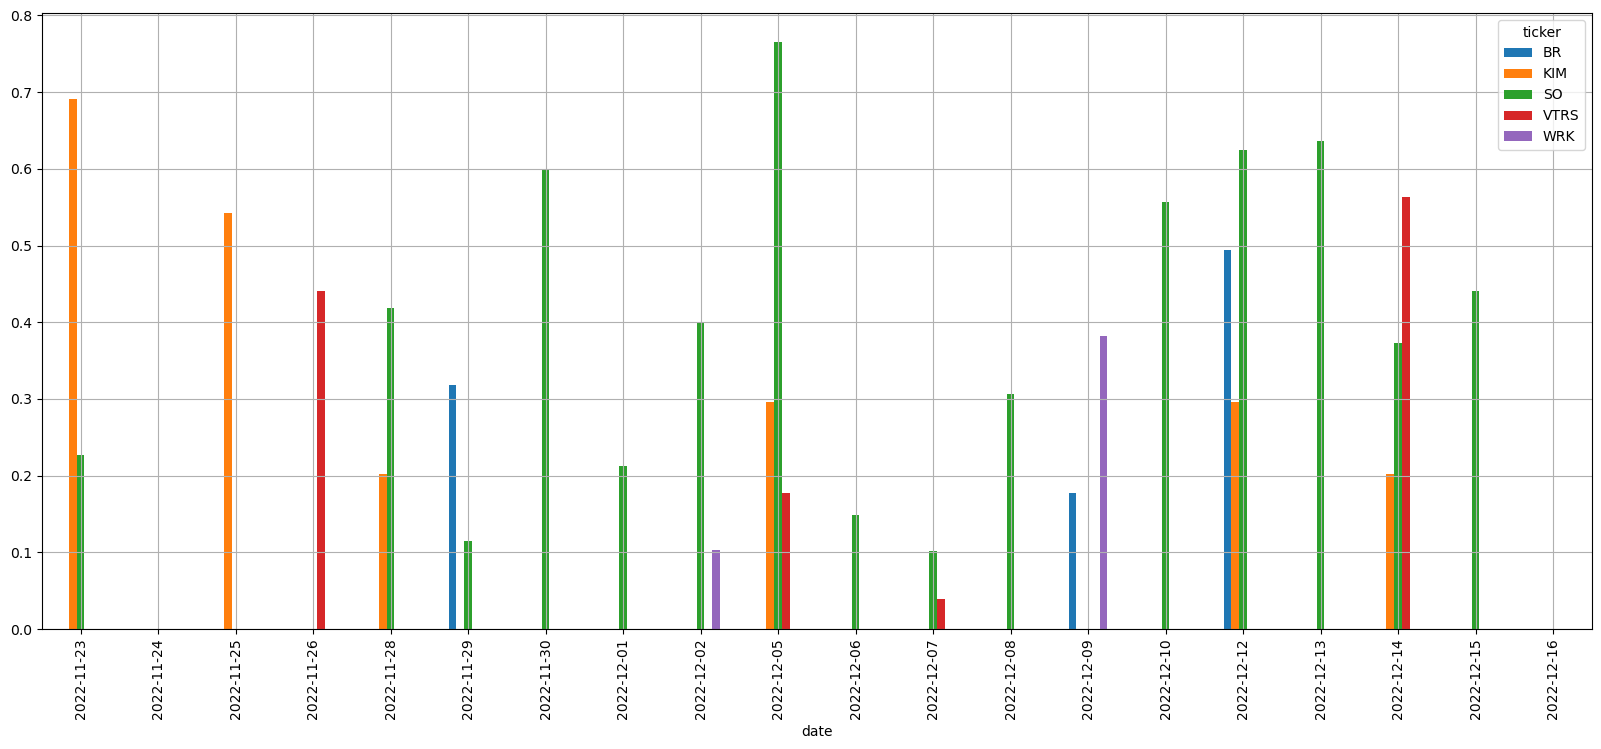

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
logger.info(f'TRADE_DATE|{datetime.today()}')
td_ameritrade.refresh_data()

full_portfolio_df = td_ameritrade.get_account_portfolio_data(masked_account_number)
logger.info('Full Portfolio:')
display(full_portfolio_df)

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
existing_stocks_to_trade = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
existing_stocks_to_trade = existing_stocks_to_trade[~existing_stocks_to_trade.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Existing Stocks to trade:')
display(existing_stocks_to_trade)

logger.info(f'Cash Equivilant:')
current_cash_balance = td_ameritrade.parse_accounts().loc[masked_account_number].currentBalances_cashBalance
cash_equivelants_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'CASH_EQUIVALENT')
display(cash_equivelants_df)
amount_for_trading = cash_equivelants_df.marketValue.sum() + existing_stocks_to_trade.marketValue.sum() + current_cash_balance
logger.info(f'Amount for trading: {amount_for_trading}')

investment_base = 1000
investment_amount = math.floor(amount_for_trading / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

stocks_to_trade = list(set(long_weights.index.to_list() + list(existing_stocks_to_trade.index.get_level_values('symbol'))))
quotes_for_stocks = td_ameritrade.get_quotes(stocks_to_trade)

display(quotes_for_stocks[['bidPrice', 'askPrice', 'regularMarketLastPrice']])

weights_for_trade = optimal_weights.loc[stocks_to_trade].copy()
weights_for_trade['optimalWeights'] = weights_for_trade['optimalWeights'].map(lambda x: 0 if x < 0.05 else x)
display(weights_for_trade)

weights_for_trade = pd.concat([weights_for_trade, quotes_for_stocks['regularMarketLastPrice']], axis=1)
display(weights_for_trade)

current_holdings = td_ameritrade.get_holdings(masked_account_number, symbols=stocks_to_trade)
current_holdings = current_holdings.droplevel('account')
display(current_holdings)

print(f'Current investment amount: {investment_amount}')
min_shares_accepted = 5
weights_for_trade['amount'] = (weights_for_trade['optimalWeights'] * investment_amount).round(0)
weights_for_trade['marketValue'] = current_holdings['marketValue']
weights_for_trade['buy/sell'] = (weights_for_trade['marketValue'] - weights_for_trade['amount']) * -1
weights_for_trade['existingShares'] = current_holdings['longQuantity'].astype(int)
weights_for_trade['deltaShares'] = (weights_for_trade['buy/sell'] / weights_for_trade['regularMarketLastPrice']).astype(int)
weights_for_trade['abs_delta_shares'] = weights_for_trade.deltaShares.abs()
weights_for_trade['deltaMarketValue'] = (weights_for_trade['deltaShares'] * weights_for_trade['regularMarketLastPrice'])
weights_for_trade['totalShares'] = (weights_for_trade['existingShares'] + weights_for_trade['deltaShares'])
weights_for_trade['totalMarketValue'] = (weights_for_trade['totalShares'] * weights_for_trade['regularMarketLastPrice'])
display(weights_for_trade)

print(f'Total Market Value: {weights_for_trade.totalMarketValue.sum()}')

for symbol, row in weights_for_trade.iterrows():
    if row.deltaShares > 0:
        instruction = 'BUY'
        quantity = row.deltaShares
    else:
        instruction = 'SELL'
        quantity = abs(row.deltaShares)
        
    if quantity >= min_shares_accepted:
        order = amc.create_limit_order(masked_account_number, symbol, 'EQUITY', quantity, instruction, 'NORMAL', 'DAY', round(row.regularMarketLastPrice, 2))
        print(order)
        td_ameritrade.place_order(order)

2022-12-16 10:19:16,764|JointHoldingsAdjustement|INFO|TRADE_DATE|2022-12-16 10:19:16.764446
2022-12-16 10:19:17,199|JointHoldingsAdjustement|INFO|Full Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 SO                0.0     71.030000             0.0   
         KIM               0.0     21.635000             0.0   
         WKHS              0.0     10.491800             0.0   
         EEENF             0.0      0.049800             0.0   
         FGPHF             0.0      0.109270             0.0   
         MMDA1             0.0      0.998869             0.0   
         BR                0.0    143.500000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 SO                  -30.8000                           -1.56   
         KIM                 -42.3292                           -2.14   
         WKHS                 25.5000                            4.47   
         EEENF                -0.0050                           -0.29   
         FGPHF              -125.0000                           -6.67   
         MMDA1                 0.0000                            0.00   
         BR                  -17.4300                           -0.92   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 SO             28.00                28.00                   0.0   
         KIM            92.00                92.00                   0.0   
         WKHS          300.00               300.00                   0.0   
         EEENF         250.00               250.00                   0.0   
         FGPHF       25000.00             25000.00                   0.0   
         MMDA1        4825.64              4825.64                   0.0   
         BR             14.00                14.00                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 SO          1939.56                  581.87   
         KIM         1938.43                  581.53   
         WKHS         595.50                  595.50   
         EEENF          1.70                    0.00   
         FGPHF       1750.00                    0.00   
         MMDA1       4825.64                    0.00   
         BR          1872.01                  561.60   

                 previousSessionLongQuantity        assetType      cusip  \
account  symbol                                                            
#---2021 SO                            28.00           EQUITY  842587107   
         KIM                           92.00           EQUITY  49446R109   
         WKHS                         300.00           EQUITY  98138J206   
         EEENF                        250.00           EQUITY  Q3394D101   
         FGPHF                      25000.00           EQUITY  Q3860H107   
         MMDA1                       4825.64  CASH_EQUIVALENT  9ZZZFD104   
         BR                            14.00           EQUITY  11133T103   

                                                       description  \
account  symbol                                                      
#---2021 SO                                                      0   
         KIM                                                     0   
         WKHS                                                    0   
         EEENF                                                   0   
         FGPHF                                                   0   
         MMDA1   FDIC INSURED DEPOSIT ACCOUNT  CORE  NOT COVERE...   
         BR                                                      0   

                              type  
account  symbol                     
#---2021 SO                      0  
         KIM                     0  
         WKHS                    0  
         EEENF                   0  
         FGPHF                   0  
         MMDA1   

2022-12-16 10:19:17,238|JointHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 SO                0.0      71.03000             0.0   
         KIM               0.0      21.63500             0.0   
         WKHS              0.0      10.49180             0.0   
         EEENF             0.0       0.04980             0.0   
         FGPHF             0.0       0.10927             0.0   
         BR                0.0     143.50000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 SO                  -30.8000                           -1.56   
         KIM                 -42.3292                           -2.14   
         WKHS                 25.5000                            4.47   
         EEENF                -0.0050                           -0.29   
         FGPHF              -125.0000                           -6.67   
         BR                  -17.4300                           -0.92   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 SO              28.0                 28.0                   0.0   
         KIM             92.0                 92.0                   0.0   
         WKHS           300.0                300.0                   0.0   
         EEENF          250.0                250.0                   0.0   
         FGPHF        25000.0              25000.0                   0.0   
         BR              14.0                 14.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 SO          1939.56                  581.87   
         KIM         1938.43                  581.53   
         WKHS         595.50                  595.50   
         EEENF          1.70                    0.00   
         FGPHF       1750.00                    0.00   
         BR          1872.01                  561.60   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 SO                             28.0    EQUITY  842587107           0   
         KIM                            92.0    EQUITY  49446R109           0   
         WKHS                          300.0    EQUITY  98138J206           0   
         EEENF                         250.0    EQUITY  Q3394D101           0   
         FGPHF                       25000.0    EQUITY  Q3860H107           0   
         BR                             14.0    EQUITY  11133T103           0   

                type  
account  symbol       
#---2021 SO        0  
         KIM       0  
         WKHS      0  
         EEENF     0  
         FGPHF     0  
         BR        0

2022-12-16 10:19:17,457|JointHoldingsAdjustement|INFO|Existing Stocks to trade:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 SO                0.0        71.030             0.0   
         KIM               0.0        21.635             0.0   
         BR                0.0       143.500             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 SO                  -30.8000                           -1.56   
         KIM                 -42.3292                           -2.14   
         BR                  -17.4300                           -0.92   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 SO              28.0                 28.0                   0.0   
         KIM             92.0                 92.0                   0.0   
         BR              14.0                 14.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 SO          1939.56                  581.87   
         KIM         1938.43                  581.53   
         BR          1872.01                  561.60   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 SO                             28.0    EQUITY  842587107           0   
         KIM                            92.0    EQUITY  49446R109           0   
         BR                             14.0    EQUITY  11133T103           0   

                type  
account  symbol       
#---2021 SO        0  
         KIM       0  
         BR        0

2022-12-16 10:19:17,482|JointHoldingsAdjustement|INFO|Cash Equivilant:


,,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,description,type
account,symbol,,,,,,,,,,,,,,,
#---2021,MMDA1,0.0,0.998869,0.0,0.0,0.0,4825.64,4825.64,0.0,4825.64,0.0,4825.64,CASH_EQUIVALENT,9ZZZFD104,FDIC INSURED DEPOSIT ACCOUNT CORE NOT COVERE...,MONEY_MARKET_FUND


2022-12-16 10:19:17,512|JointHoldingsAdjustement|INFO|Amount for trading: 10575.64
Amount to invest: 10000


,bidPrice,askPrice,regularMarketLastPrice
WRK,35.00,35.03,35.0100
SO,69.26,69.28,69.2800
VTRS,10.90,10.91,10.9000
BR,133.61,133.85,133.7150
KIM,21.06,21.07,21.0699


,optimalWeights
WRK,0.200000
SO,0.200000
VTRS,0.147486
BR,0.200000
KIM,0.200000


,optimalWeights,regularMarketLastPrice
WRK,0.200000,35.0100
SO,0.200000,69.2800
VTRS,0.147486,10.9000
BR,0.200000,133.7150
KIM,0.200000,21.0699


,marketValue,longQuantity
symbol,,
BR,1872.01,14.0
KIM,1938.43,92.0
SO,1939.56,28.0
VTRS,0.00,0.0
WRK,0.00,0.0


Current investment amount: 10000


,optimalWeights,regularMarketLastPrice,amount,marketValue,buy/sell,existingShares,deltaShares,abs_delta_shares,deltaMarketValue,totalShares,totalMarketValue
WRK,0.200000,35.0100,2000.0,0.00,2000.00,0,57,57,1995.5700,57,1995.5700
SO,0.200000,69.2800,2000.0,1939.56,60.44,28,0,0,0.0000,28,1939.8400
VTRS,0.147486,10.9000,1475.0,0.00,1475.00,0,135,135,1471.5000,135,1471.5000
BR,0.200000,133.7150,2000.0,1872.01,127.99,14,0,0,0.0000,14,1872.0100
KIM,0.200000,21.0699,2000.0,1938.43,61.57,92,2,2,42.1398,94,1980.5706


Total Market Value: 9259.490600000001
{'account': '#---2021', 'symbol': 'WRK', 'asset_type': 'EQUITY', 'quantity': 57.0, 'instruction': 'BUY', 'session': 'NORMAL', 'duration': 'DAY', 'order_type': 'LIMIT', 'price': 35.01}
Placed LIMIT BUY order on #---2021 for 57.0 shares of WRK at 35.01
{'account': '#---2021', 'symbol': 'VTRS', 'asset_type': 'EQUITY', 'quantity': 135.0, 'instruction': 'BUY', 'session': 'NORMAL', 'duration': 'DAY', 'order_type': 'LIMIT', 'price': 10.9}
Placed LIMIT BUY order on #---2021 for 135.0 shares of VTRS at 10.9
